In this notebook, we extract significantly spatially varying genes and show them in three clusters.

Load relevant packages, including SpatialDE:

In [1]:
import sys,os
path = '/nfs/team283/aa16/InSituCellTools/'
os.chdir(path)
sys.path.append(path)

In [2]:
%pylab inline
import pandas as pd
import NaiveDE
import SpatialDE
import statsmodels.stats.multitest as multi
import scipy.stats as ss
import pickle as pickle
import scipy as sc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


Load the data and remove negative probes for this analysis:

In [3]:
adata = pickle.load(open('../KR_NAS/data/nanostringWTA_fetailBrain_AnnData.p',  "rb"))
adata = adata[:,adata.var_names != 'NegProbe-WTX']

Choose the data from 19pcw replicates at radial position 1 and 3:

In [4]:
subset_19pcw = [adata.obs['Radial_position'][i] in (1,3) and
                adata.obs['AOI_type'][i] == 'HOPXpos' and
                adata.obs['age'][i] == '19pcw' and
                adata.obs['slide'][i] == '00MU' for i in range(np.shape(adata.obs)[0])]
print(np.sum(subset_19pcw))
subset_14pcw = [adata.obs['Radial_position'][i] in (1,3) and
                adata.obs['AOI_type'][i] == 'HOPXpos' and
                adata.obs['age'][i] == '14pcw' and
                adata.obs['slide'][i] == '00MW' for i in range(np.shape(adata.obs)[0])]
print(np.sum(subset_14pcw))
subset_19pcw_res = [adata.obs['Radial_position'][i] in (1,3) and
                adata.obs['AOI_type'][i] == 'Residual' and
                adata.obs['age'][i] == '19pcw' and
                adata.obs['slide'][i] == '00MU' for i in range(np.shape(adata.obs)[0])]
print(np.sum(subset_19pcw_res))
subset_14pcw_res = [adata.obs['Radial_position'][i] in (1,3) and
                adata.obs['AOI_type'][i] == 'Residual' and
                adata.obs['age'][i] == '14pcw' and
                adata.obs['slide'][i] == '00MW' for i in range(np.shape(adata.obs)[0])]
print(np.sum(subset_14pcw_res))
subset_19pcw_ring = [adata.obs['Radial_position'][i] in (1,3) and
                adata.obs['AOI_type'][i] == 'Ring' and
                adata.obs['age'][i] == '19pcw' and
                adata.obs['slide'][i] == '00MU' for i in range(np.shape(adata.obs)[0])]
print(np.sum(subset_19pcw_ring))
subset_14pcw_ring = [adata.obs['Radial_position'][i] in (1,3) and
                adata.obs['AOI_type'][i] == 'Ring' and
                adata.obs['age'][i] == '14pcw' and
                adata.obs['slide'][i] == '00MW' for i in range(np.shape(adata.obs)[0])]
print(np.sum(subset_14pcw_ring))

10
10
10
9
10
10


Reduce anndata to genes expressed in selected ROIs:

In [5]:
adata_subset = adata[subset_19pcw, :]
corrected_simple = [adata_subset.X[j,:] > adata_subset.obs['GeoLOD2.5_01'].iloc[j]
                                    for j in range(len(adata_subset.obs['GeoLOD2.5_01']))]
subset = np.sum(corrected_simple, axis = 0) > 3
adata_19pcw = adata[:,subset]

In [6]:
adata_subset = adata[subset_14pcw, :]
corrected_simple = [adata_subset.X[j,:] > adata_subset.obs['GeoLOD2.5_01'].iloc[j]
                                    for j in range(len(adata_subset.obs['GeoLOD2.5_01']))]
subset = np.sum(corrected_simple, axis = 0) > 3
adata_14pcw = adata[:,subset]

Prepare data for spatialDE using both normal and corrected counts:

In [8]:
adata_19pcw.layers['Stabilized'] = NaiveDE.stabilize(adata_19pcw.X)
adata_19pcw.obs['TotalCounts'] = np.sum(adata_19pcw.X, axis = 1)

adata_19pcw.layers['TotalCountsRegressed'] = NaiveDE.regress_out(adata_19pcw.obs, adata_19pcw.layers['Stabilized'].T, 'np.log(TotalCounts)').T

input_data_19pcw = pd.DataFrame(adata_19pcw.layers['TotalCountsRegressed'][subset_19pcw,:], index = adata_19pcw.obs['Sanger_sampleID'][subset_19pcw],
                   columns = adata_19pcw.var_names)
adata_19pcw.layers['Stabilized_corrected'] = NaiveDE.stabilize(adata_19pcw.layers['X_Corrected_V2'])
adata_19pcw.obs['TotalCounts_corrected'] = np.sum(adata_19pcw.layers['X_Corrected_V2'], axis = 1)
adata_19pcw.layers['TotalCountsRegressed_corrected'] = NaiveDE.regress_out(adata_19pcw.obs, adata_19pcw.layers['Stabilized_corrected'].T, 'np.log(TotalCounts_corrected)').T
input_data_corrected_19pcw = pd.DataFrame(adata_19pcw.layers['TotalCountsRegressed_corrected'][subset_19pcw,:], index = adata_19pcw.obs['Sanger_sampleID'][subset_19pcw],
                   columns = adata_19pcw.var_names)
input_coordinates_19pcw = adata_19pcw.obs.loc[subset_19pcw,('Radial_position', 'VCDepth')].rename(columns={"Radial_position": "x", "VCDepth": "y"})
adata_19pcw.layers['CPM'] = np.asarray([adata_19pcw.X[i,:]/adata_19pcw.obs['TotalCounts'][i] for i in range(len(adata_19pcw.obs['TotalCounts']))])*10**6
adata_19pcw.layers['CPM_corrected'] = np.asarray([adata_19pcw.layers['X_Corrected_V2'][i,:]/adata_19pcw.obs['TotalCounts_corrected'][i] for i in range(len(adata_19pcw.obs['TotalCounts_corrected']))])*10**6
adata_19pcw.layers['zscore_19pcw_corrected'] = sc.stats.zscore(np.log2(adata_19pcw.layers['CPM_corrected']+1), axis = 0)
adata_19pcw.layers['zscore_19pcw_corrected'][subset_19pcw,:] = sc.stats.zscore(np.log2(adata_19pcw.layers['CPM_corrected'][subset_19pcw,:]+1), axis = 0)

In [9]:
adata_14pcw.layers['Stabilized'] = NaiveDE.stabilize(adata_14pcw.X)
adata_14pcw.obs['TotalCounts'] = np.sum(adata_14pcw.X, axis = 1)

adata_14pcw.layers['TotalCountsRegressed'] = NaiveDE.regress_out(adata_14pcw.obs, adata_14pcw.layers['Stabilized'].T, 'np.log(TotalCounts)').T

input_data_14pcw = pd.DataFrame(adata_14pcw.layers['TotalCountsRegressed'][subset_14pcw,:], index = adata_14pcw.obs['Sanger_sampleID'][subset_14pcw],
                   columns = adata_14pcw.var_names)
adata_14pcw.layers['Stabilized_corrected'] = NaiveDE.stabilize(adata_14pcw.layers['X_Corrected_V2'])
adata_14pcw.obs['TotalCounts_corrected'] = np.sum(adata_14pcw.layers['X_Corrected_V2'], axis = 1)
adata_14pcw.layers['TotalCountsRegressed_corrected'] = NaiveDE.regress_out(adata_14pcw.obs, adata_14pcw.layers['Stabilized_corrected'].T, 'np.log(TotalCounts_corrected)').T
input_data_corrected_14pcw = pd.DataFrame(adata_14pcw.layers['TotalCountsRegressed_corrected'][subset_14pcw,:], index = adata_14pcw.obs['Sanger_sampleID'][subset_14pcw],
                   columns = adata_14pcw.var_names)
input_coordinates_14pcw = adata_14pcw.obs.loc[subset_14pcw,('Radial_position', 'VCDepth')].rename(columns={"Radial_position": "x", "VCDepth": "y"})
adata_14pcw.layers['CPM'] = np.asarray([adata_14pcw.X[i,:]/adata_14pcw.obs['TotalCounts'][i] for i in range(len(adata_14pcw.obs['TotalCounts']))])*10**6
adata_14pcw.layers['zscore_14pcw'] = sc.stats.zscore(np.log2(adata_14pcw.layers['CPM']+1), axis = 0)
adata_14pcw.layers['CPM_corrected'] = np.asarray([adata_14pcw.layers['X_Corrected_V2'][i,:]/adata_14pcw.obs['TotalCounts_corrected'][i] for i in range(len(adata_14pcw.obs['TotalCounts_corrected']))])*10**6
adata_14pcw.layers['zscore_14pcw_corrected'] = sc.stats.zscore(np.log2(adata_14pcw.layers['CPM_corrected']+1), axis = 0)
adata_14pcw.layers['zscore_14pcw_corrected'][subset_14pcw,:] = sc.stats.zscore(np.log2(adata_14pcw.layers['CPM_corrected'][subset_14pcw,:]+1), axis = 0)

In [10]:
adata.layers['Stabilized'] = NaiveDE.stabilize(adata.X)
adata.obs['TotalCounts'] = np.sum(adata.X, axis = 1)

adata.layers['TotalCountsRegressed'] = NaiveDE.regress_out(adata.obs, adata.layers['Stabilized'].T, 'np.log(TotalCounts)').T

adata.layers['Stabilized_corrected'] = NaiveDE.stabilize(adata.layers['X_Corrected_V2'])
adata.obs['TotalCounts_corrected'] = np.sum(adata.layers['X_Corrected_V2'], axis = 1)
adata.layers['TotalCountsRegressed_corrected'] = NaiveDE.regress_out(adata.obs, adata.layers['Stabilized_corrected'].T, 'np.log(TotalCounts_corrected)').T

adata.layers['CPM'] = np.asarray([adata.X[i,:]/adata.obs['TotalCounts'][i] for i in range(len(adata.obs['TotalCounts']))])*10**6
adata.layers['zscore_19pcw'] = sc.stats.zscore(np.log2(adata.layers['CPM']+1), axis = 0)
adata.layers['CPM_corrected'] = np.asarray([adata.layers['X_Corrected_V2'][i,:]/adata.obs['TotalCounts_corrected'][i] for i in range(len(adata.obs['TotalCounts_corrected']))])*10**6
adata.layers['zscore_corrected'] = sc.stats.zscore(np.log2(adata.layers['CPM_corrected']+1), axis = 0)
adata.layers['zscore_corrected'][np.array(subset_19pcw_ring) + np.array(subset_14pcw_ring) + np.array(subset_14pcw) + np.array(subset_14pcw_res) + np.array(subset_19pcw) + np.array(subset_19pcw_res),:] = sc.stats.zscore(np.log2(adata.layers['CPM_corrected'][np.array(subset_19pcw_ring) + np.array(subset_14pcw_ring) + np.array(subset_14pcw) + np.array(subset_14pcw_res) + np.array(subset_19pcw) + np.array(subset_19pcw_res) ,:]+1), axis = 0)
# adata.layers['zscore_14pcw_corrected'][subset_14pcw_res,:] = sc.stats.zscore(np.log2(adata.layers['CPM_corrected'][subset_14pcw_res,:]+1), axis = 0)
# adata.layers['zscore_19pcw_corrected'][subset_19pcw_res,:] = sc.stats.zscore(np.log2(adata.layers['CPM_corrected'][subset_19pcw_res,:]+1), axis = 0)

In [11]:
adata_14pcw.layers['zscore_14pcw_corrected'][subset_14pcw_res,:] = sc.stats.zscore(np.log2(adata_14pcw.layers['CPM_corrected'][subset_14pcw_res,:]+1), axis = 0)
adata_19pcw.layers['zscore_19pcw_corrected'][subset_19pcw_res,:] = sc.stats.zscore(np.log2(adata_19pcw.layers['CPM_corrected'][subset_19pcw_res,:]+1), axis = 0)

Run spatialDE:

In [12]:
results_19pcw = SpatialDE.run(input_coordinates_19pcw, input_data_19pcw)
results_corrected_19pcw = SpatialDE.run(input_coordinates_19pcw, input_data_corrected_19pcw)
results_14pcw = SpatialDE.run(input_coordinates_14pcw, input_data_14pcw)
results_corrected_14pcw = SpatialDE.run(input_coordinates_14pcw, input_data_corrected_14pcw)

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/4390 [00:00<?, ?it/s]

Get list of all spatially varying genes:

In [13]:
# threshold = 0.1
# print('significance threshold (fdr/qval):', threshold)
# results = results.sort_values('qval')
# genes_ranked = np.array(results['g'])
# genes_significant_fdr = genes_ranked[multi.multipletests(results['pval'], method = 'fdr_bh')[1] < threshold]
# genes_significant_qval = genes_ranked[results['qval'] < 0.05]
# print('genes significant (fdr):', len(genes_significant_fdr))
# print('genes significant (qval):', len(genes_significant_qval))
# overlap = sum([genes_significant_fdr[i] in genes_significant_qval for i in range(len(genes_significant_fdr))])/len(genes_significant_fdr)
# print('overlap_fdr_qval:', overlap)
# percent_significant_fdr = len(genes_significant_fdr)/len(genes_ranked)
# percent_significant_qval = len(genes_significant_qval)/len(genes_ranked)
# print('percent_significant_fdr:', percent_significant_fdr)
# print('percent_significant_qval:', percent_significant_qval)
# threshold = 0.1
# print('significance threshold (fdr/qval):', threshold)
# results = results.sort_values('qval')
# genes_ranked = np.array(results_corrected['g'])
# genes_significant_fdr = genes_ranked[multi.multipletests(results_corrected['pval'], method = 'fdr_bh')[1] < threshold]
# genes_significant_qval = genes_ranked[results_corrected['qval'] < 0.05]
# print('genes significant (fdr):', len(genes_significant_fdr))
# print('genes significant (qval):', len(genes_significant_qval))
# overlap = sum([genes_significant_fdr[i] in genes_significant_qval for i in range(len(genes_significant_fdr))])/len(genes_significant_fdr)
# print('overlap_fdr_qval:', overlap)
# percent_significant_fdr = len(genes_significant_fdr)/len(genes_ranked)
# percent_significant_qval = len(genes_significant_qval)/len(genes_ranked)
# print('percent_significant_fdr:', percent_significant_fdr)
# print('percent_significant_qval:', percent_significant_qval)
# np.intersect1d(results.sort_values('pval').iloc[0:100]['g'],
#                 results_corrected.loc[results_corrected['pval'] < 0.05,:]['g'])

In [14]:
print(len(results_corrected_19pcw.loc[results_corrected_19pcw['pval'] < 0.05,:]['g']))
print(len(results_corrected_14pcw.loc[results_corrected_14pcw['pval'] < 0.05,:]['g']))

41
28


In [15]:
genes_19pcw = np.array(results_corrected_19pcw.loc[results_corrected_19pcw['pval'] < 0.05,:]['g'])
genes_14pcw = np.array(results_corrected_14pcw.loc[results_corrected_14pcw['pval'] < 0.05,:]['g'])

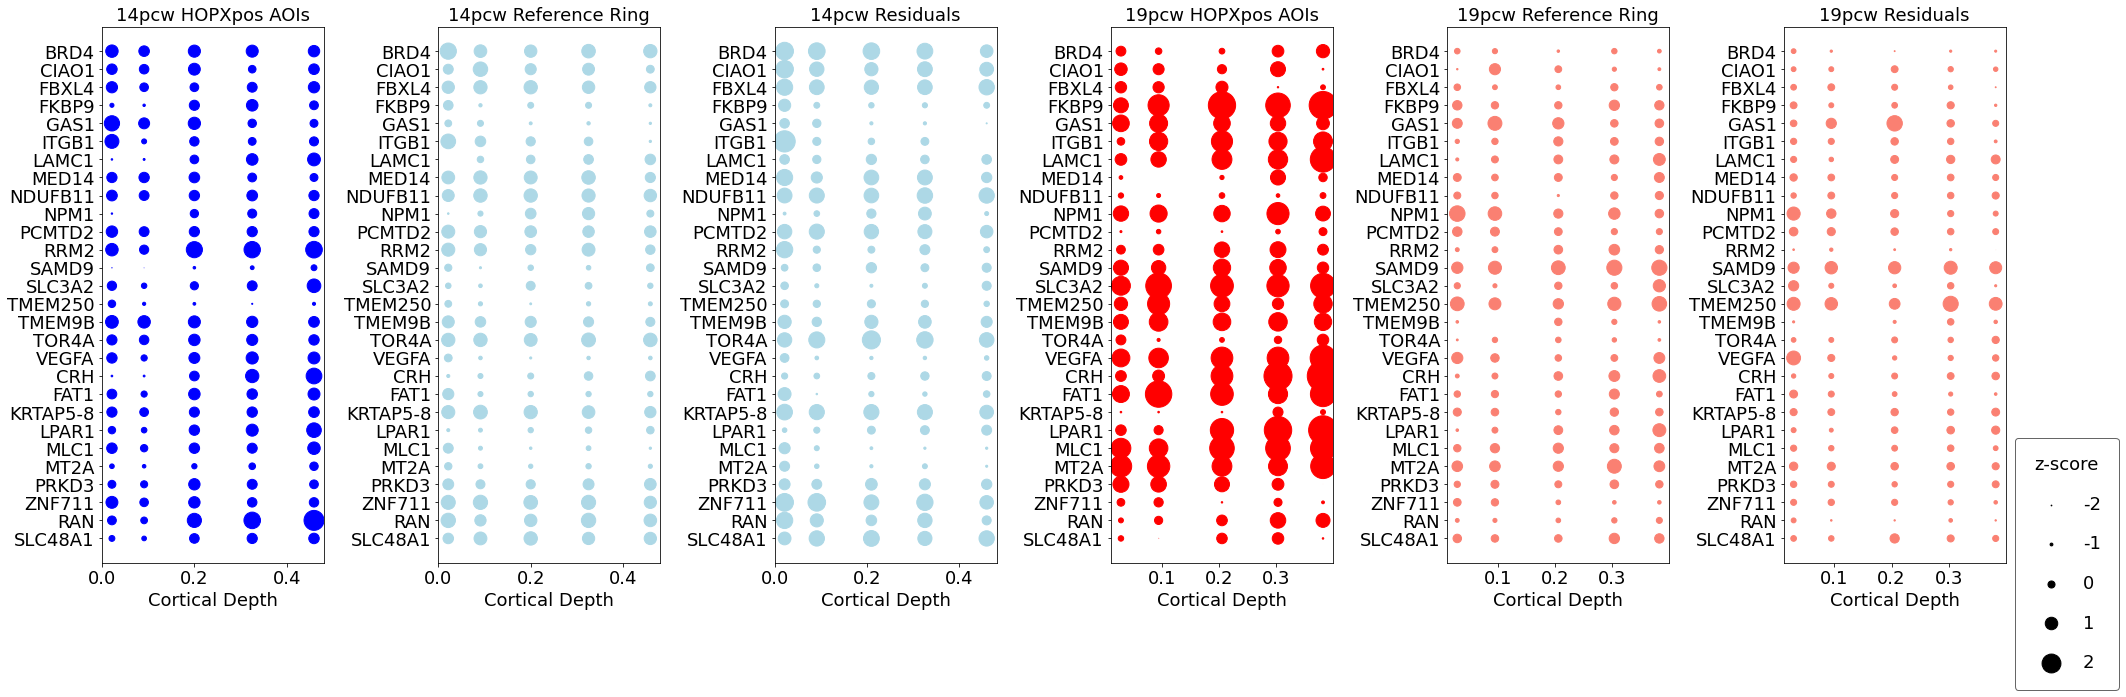

In [16]:
scaling = 5
power = 3

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

markers_genes = np.flipud(genes_14pcw)
fig, ax = plt.subplots(1,6, figsize = (30,10))

subset_list = [subset_14pcw, subset_14pcw_ring, subset_14pcw_res, subset_19pcw, subset_19pcw_ring, subset_19pcw_res]
title_list = ['14pcw HOPXpos AOIs','14pcw Reference Ring', '14pcw Residuals',
              '19pcw HOPXpos AOIs', '19pcw Reference Ring', '19pcw Residuals']
colour_list = ['blue', 'lightblue', 'lightblue', 'red', 'salmon', 'salmon']

for k in range(len(subset_list)):
    genesForPlot = np.repeat(markers_genes,np.ceil(sum(subset_list[k])/2))
    vcForPlot = np.array([adata.obs['VCDepth'].loc[subset_list[k]] for i in range(len(markers_genes))])
    countsForPlot = np.array([adata.layers['zscore_corrected'][subset_list[k], adata.var_names == markers_genes[i]] for i in range(len(markers_genes))])
    unique_vc = np.unique(np.round(vcForPlot,1))
    newVCForPlot = np.empty((len(markers_genes),len(unique_vc)))
    newCountsForPlot = np.empty((len(markers_genes),len(unique_vc)))
    for i in range(len(markers_genes)):
        for j in range(len(unique_vc)):
            newVCForPlot[i,j] = np.mean(vcForPlot[i,np.round(vcForPlot,1)[i,:] == unique_vc[j]])
            newCountsForPlot[i,j] = np.mean(countsForPlot[i,np.round(vcForPlot,1)[i,:] == unique_vc[j]])
    newVCForPlot = newVCForPlot.flatten()
    ax[k].scatter(newVCForPlot, genesForPlot, s=((-np.amin(newCountsForPlot) + newCountsForPlot)**power)*scaling,
                  marker = 'o', facecolors = 'none',
                  c = colour_list[k])
    ax[k].set_xlabel('Cortical Depth')
    ax[k].set_title(title_list[k])
#make a legend:
pws = [1,-2, -1,0, 1,2]
for pw in pws:
    plt.scatter([], [], s=0.1*scaling + ((-np.amin(newCountsForPlot) + pw)**power)*scaling, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="z-score", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.25))
plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/SupplementaryFigure_HOPXpos_spatialGenes_14pcw.pdf', bbox_extra_artists=(lgd,))

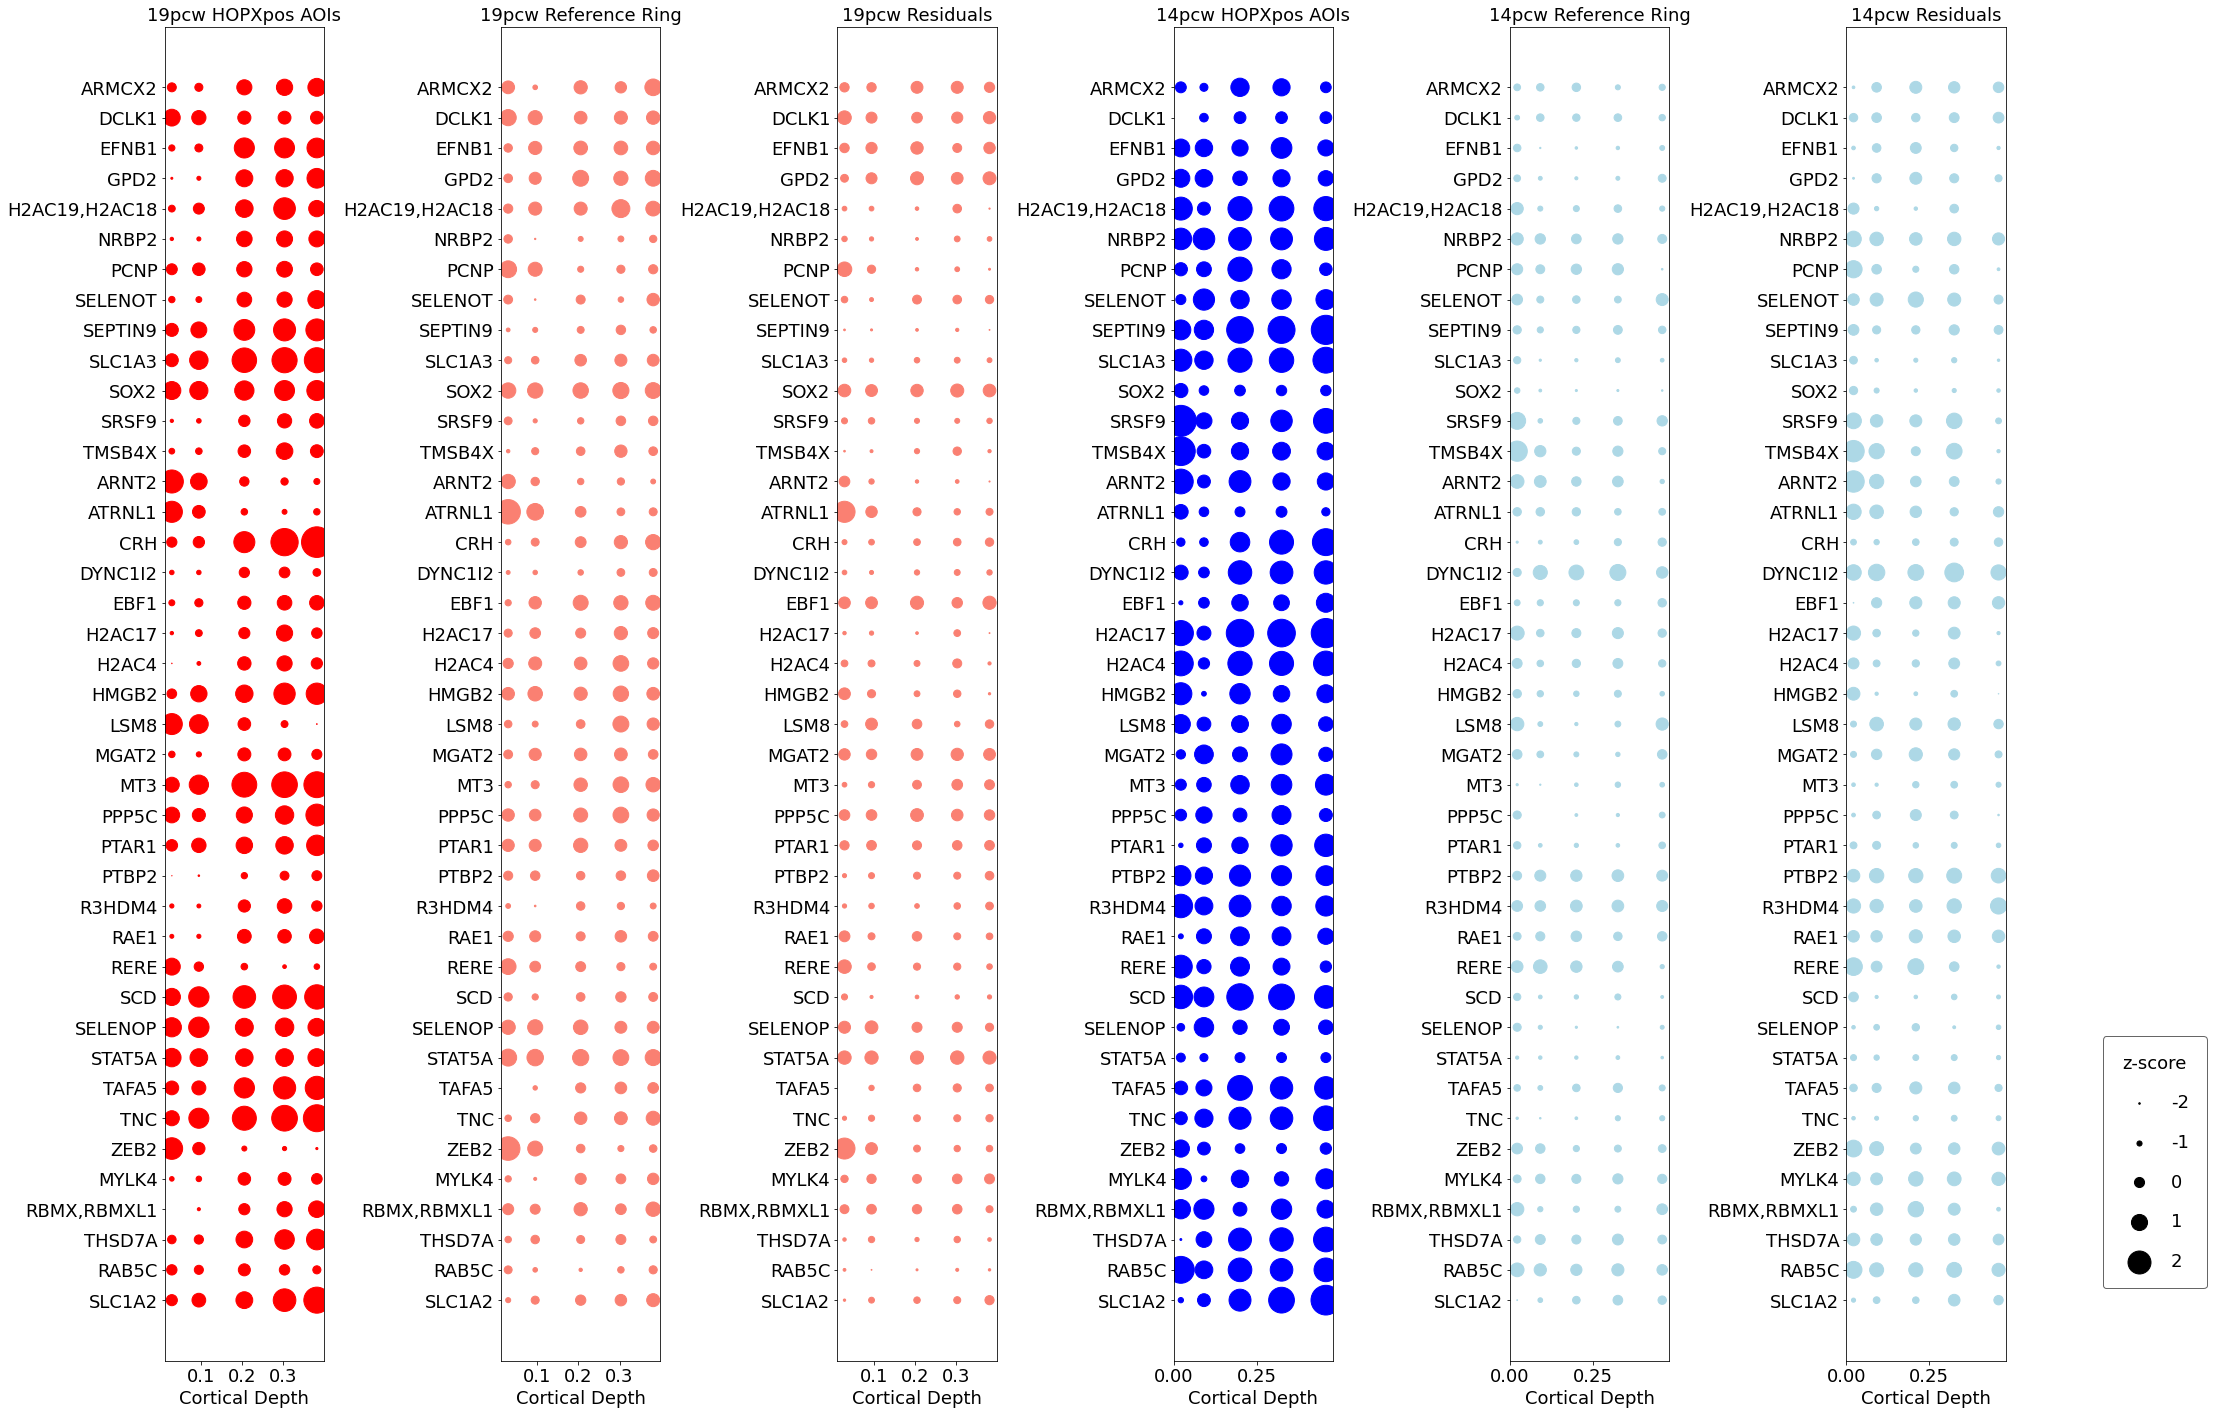

In [17]:
scaling = 5
power = 3

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

markers_genes = np.flipud(genes_19pcw)
fig, ax = plt.subplots(1,6, figsize = (30,20))

subset_list = [subset_19pcw, subset_19pcw_ring, subset_19pcw_res, subset_14pcw, subset_14pcw_ring, subset_14pcw_res]
title_list = ['19pcw HOPXpos AOIs','19pcw Reference Ring', '19pcw Residuals',
              '14pcw HOPXpos AOIs', '14pcw Reference Ring', '14pcw Residuals']
colour_list = ['red', 'salmon', 'salmon', 'blue', 'lightblue', 'lightblue', ]

for k in range(len(subset_list)):
    genesForPlot = np.repeat(markers_genes,np.ceil(sum(subset_list[k])/2))
    vcForPlot = np.array([adata.obs['VCDepth'].loc[subset_list[k]] for i in range(len(markers_genes))])
    countsForPlot = np.array([adata.layers['zscore_corrected'][subset_list[k], adata.var_names == markers_genes[i]] for i in range(len(markers_genes))])
    unique_vc = np.unique(np.round(vcForPlot,1))
    newVCForPlot = np.empty((len(markers_genes),5))
    newCountsForPlot = np.empty((len(markers_genes),5))
    for i in range(len(markers_genes)):
        for j in range(5):
            newVCForPlot[i,j] = np.mean(vcForPlot[i,np.round(vcForPlot,1)[i,:] == unique_vc[j]])
            newCountsForPlot[i,j] = np.mean(countsForPlot[i,np.round(vcForPlot,1)[i,:] == unique_vc[j]])
    newVCForPlot = newVCForPlot.flatten()
    ax[k].scatter(newVCForPlot, genesForPlot, s=((-np.amin(newCountsForPlot) + newCountsForPlot)**power)*scaling,
                  marker = 'o', facecolors = 'none',
                  c = colour_list[k])
    ax[k].set_xlabel('Cortical Depth')
    ax[k].set_title(title_list[k])
#make a legend:
pws = [1,-2, -1,0, 1,2]
for pw in pws:
    plt.scatter([], [], s=0.1*scaling + ((-np.amin(newCountsForPlot) + pw)**power)*scaling, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="z-score", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.25))
plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/SupplementaryFigure_HOPXpos_spatialGenes_19pcw.pdf', bbox_extra_artists=(lgd,))